Project Completed by **Ahmed Salama**
* [GitHub](https://github.com/ahmedsalama00)
* [Linked In](https://www.linkedin.com/in/ahmedsalamaa00/)
* [My Portfolio ](https://ahmedsalama00.github.io/Ahmed)
* [Sentiment Analysis Repo](https://github.com/ahmedsalama00/Sentiment-Analysis)

In [29]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
df = pd.read_csv('/kaggle/input/twitter/Twitter_Data.csv')

print(f"Loaded {len(df):,} tweets")
print(f"\nDataset Info:")
print(f"   - Rows: {len(df):,}")
print(f"   - Columns: {len(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))


print(f"\nMissing values:")
print(df.isnull().sum())

df = df.dropna()
print(f"\nAfter removing missing values: {len(df):,} tweets")

Loaded 162,980 tweets

Dataset Info:
   - Rows: 162,980
   - Columns: 2

First 3 rows:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0

Missing values:
clean_text    4
category      7
dtype: int64

After removing missing values: 162,969 tweets


## 2. Data Distribution Analysis


Category distribution:
category
-1.0    35509
 0.0    55211
 1.0    72249
Name: count, dtype: int64

Distribution by names:
category_name
Positive    72249
Neutral     55211
Negative    35509
Name: count, dtype: int64

Text length statistics:
   - Average length: 124 characters
   - Shortest text: 1 characters
   - Longest text: 274 characters


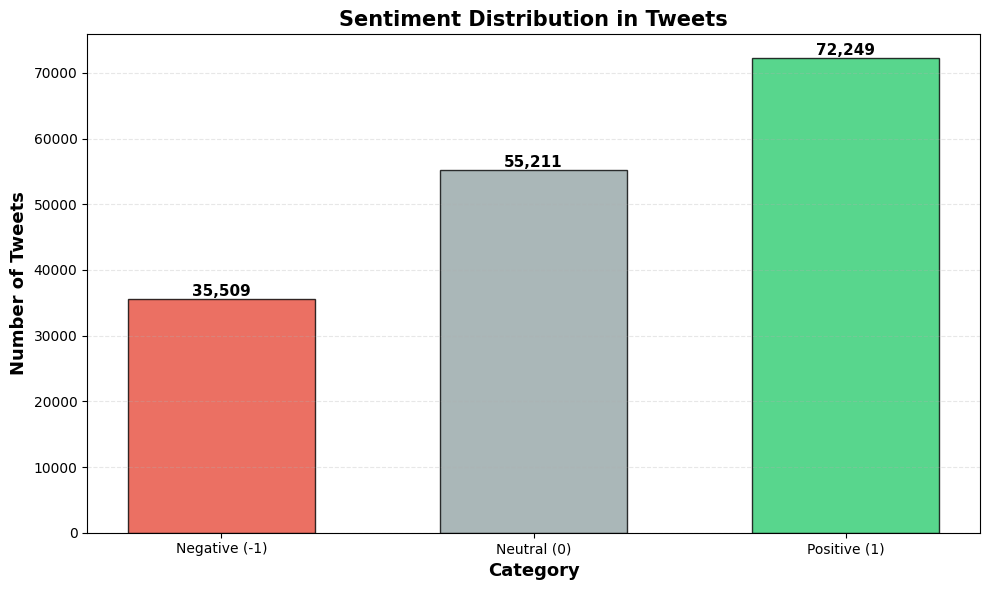

In [31]:
print("\nCategory distribution:")
print(df['category'].value_counts().sort_index())

category_names = {-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'}
df['category_name'] = df['category'].map(category_names)

print("\nDistribution by names:")
print(df['category_name'].value_counts())

plt.figure(figsize=(10, 6))
category_counts = df['category'].value_counts().sort_index()
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
bars = plt.bar([-1, 0, 1], category_counts.values, color=colors, alpha=0.8, edgecolor='black', width=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Category', fontsize=13, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=13, fontweight='bold')
plt.title('Sentiment Distribution in Tweets', fontsize=15, fontweight='bold')
plt.xticks([-1, 0, 1], ['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()


df['text_length'] = df['clean_text'].str.len()
print(f"\nText length statistics:")
print(f"   - Average length: {df['text_length'].mean():.0f} characters")
print(f"   - Shortest text: {df['text_length'].min()} characters")
print(f"   - Longest text: {df['text_length'].max()} characters")

## 3. Data Preparation

In [32]:
df['label'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})

X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split:")
print(f"   - Training data: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Testing data: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nCategory distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = ['Negative', 'Neutral', 'Positive'][label]
    print(f"   - {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")


Data split:
   - Training data: 130,375 (80.0%)
   - Testing data: 32,594 (20.0%)

Category distribution in training:
   - Negative: 28,407 (21.8%)
   - Neutral: 44,169 (33.9%)
   - Positive: 57,799 (44.3%)


## 4. Model 1: Logistic Regression

Number of features: 5,000

Accuracy: 0.9071 (90.71%)

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8383    0.8524    0.8453      7102
     Neutral     0.8942    0.9726    0.9317     11042
    Positive     0.9559    0.8839    0.9185     14450

    accuracy                         0.9071     32594
   macro avg     0.8961    0.9030    0.8985     32594
weighted avg     0.9094    0.9071    0.9070     32594



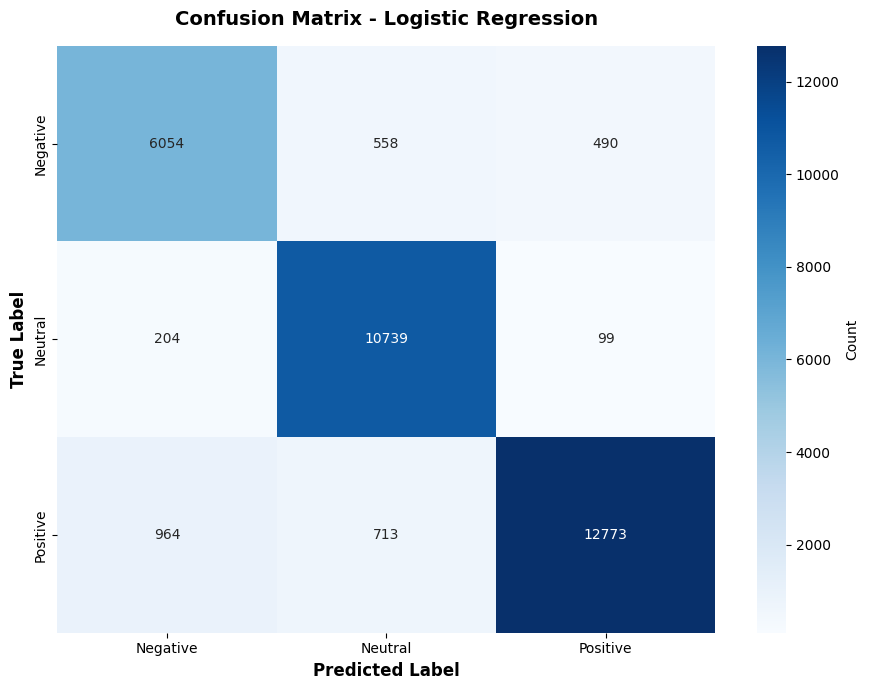

In [34]:
tfidf_lr = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf_lr.fit_transform(X_train)
X_test_tfidf = tfidf_lr.transform(X_test)

print(f"Number of features: {X_train_tfidf.shape[1]:,}")

lr_model = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced', n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, y_pred_lr)

print(f"\nAccuracy: {lr_acc:.4f} ({lr_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, 
                          target_names=['Negative', 'Neutral', 'Positive'],
                          digits=4))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()

## 5. Model 2: XGBoost


Accuracy: 0.8541 (85.41%)

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9023    0.6531    0.7577      7102
     Neutral     0.7735    0.9831    0.8658     11042
    Positive     0.9200    0.8545    0.8860     14450

    accuracy                         0.8541     32594
   macro avg     0.8653    0.8302    0.8365     32594
weighted avg     0.8665    0.8541    0.8512     32594



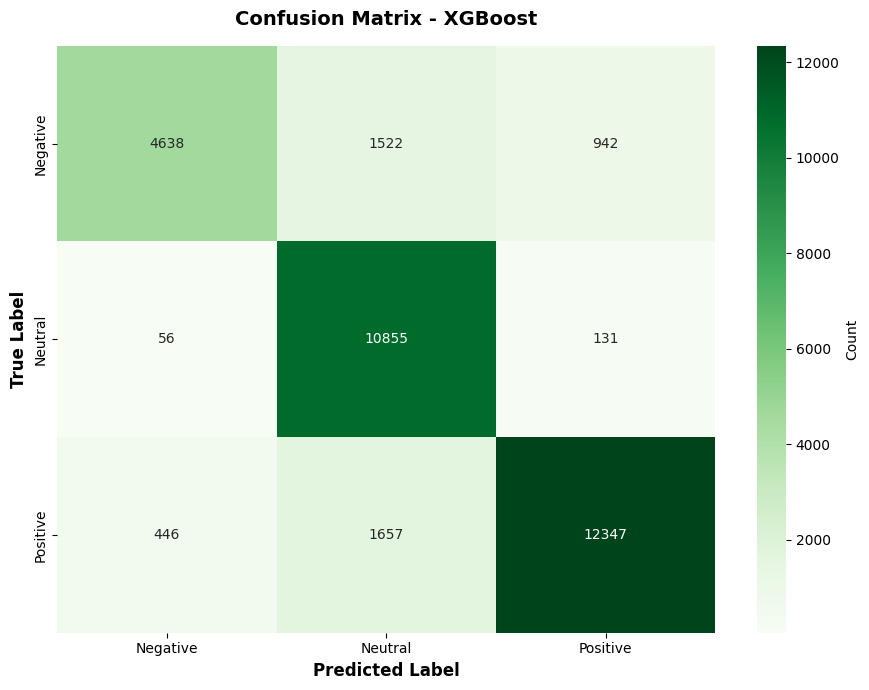

In [35]:
tfidf_xgb = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_tfidf_xgb = tfidf_xgb.fit_transform(X_train)
X_test_tfidf_xgb = tfidf_xgb.transform(X_test)

xgb_model = xgb.XGBClassifier(
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    tree_method='hist'
)
xgb_model.fit(X_train_tfidf_xgb, y_train)

y_pred_xgb = xgb_model.predict(X_test_tfidf_xgb)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print(f"\nAccuracy: {xgb_acc:.4f} ({xgb_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['Negative', 'Neutral', 'Positive'],
                          digits=4))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()

## 6. Model 3: LSTM


Model parameters:
   - Vocabulary size: 10,000
   - Sequence length: 150
   - Embedding dimension: 128
Training data shape: (130375, 150)
Testing data shape: (32594, 150)

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 450s 271ms/step - accuracy: 0.7628 - loss: 0.5724 - val_accuracy: 0.9555 - val_loss: 0.1482
Epoch 2/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 450s 276ms/step - accuracy: 0.9618 - loss: 0.1414 - val_accuracy: 0.9638 - val_loss: 0.1290
Epoch 3/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 451s 276ms/step - accuracy: 0.9715 - loss: 0.1050 - val_accuracy: 0.9685 - val_loss: 0.1198
Epoch 4/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 448s 275ms/step - accuracy: 0.9775 - loss: 0.0809 - val_accuracy: 0.9663 - val_loss: 0.1327
Epoch 5/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 460s 282ms/step - accuracy: 0.9824 - loss: 0.0619 - val_accuracy: 0.9654 - val_loss: 0.1495
Epoch 6/10
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 448s 275ms/step - accuracy: 0.9866 - loss: 0.0483 - val_accuracy: 0.9638 - val_loss: 0.1498
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

Accuracy: 0.9668 (96.68%)

Classification Report:
              precision    recall  f1-score   support

    Neg

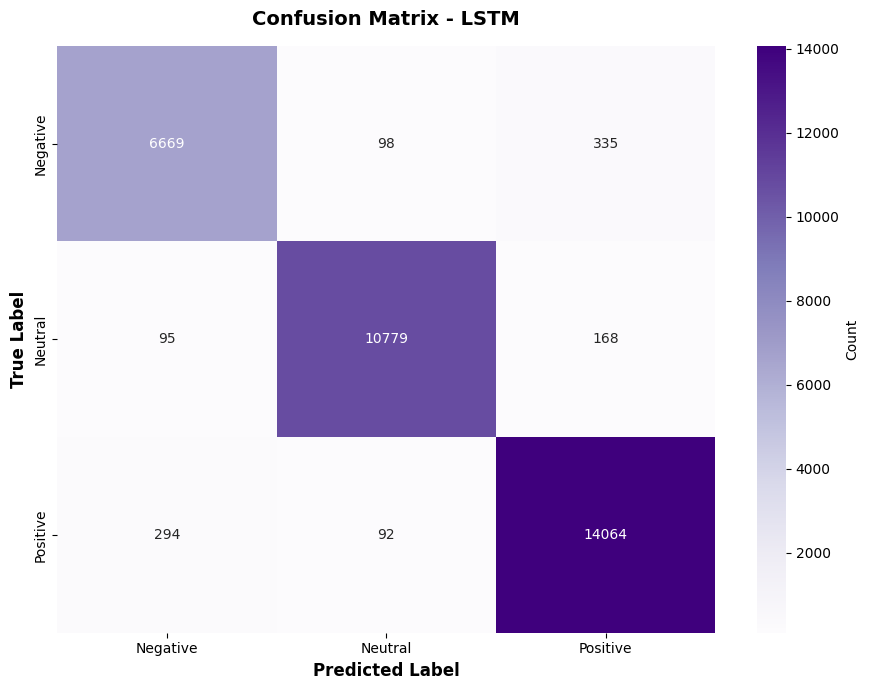

In [37]:
max_words = 10000
max_len = 150
embedding_dim = 128

print(f"\nModel parameters:")
print(f"   - Vocabulary size: {max_words:,}")
print(f"   - Sequence length: {max_len}")
print(f"   - Embedding dimension: {embedding_dim}")

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape: {X_test_pad.shape}")

lstm_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred_probs = lstm_model.predict(X_test_pad, verbose=0)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
lstm_acc = accuracy_score(y_test, y_pred_lstm)

print(f"\nAccuracy: {lstm_acc:.4f} ({lstm_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, 
                          target_names=['Negative', 'Neutral', 'Positive'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()

## Plot training history

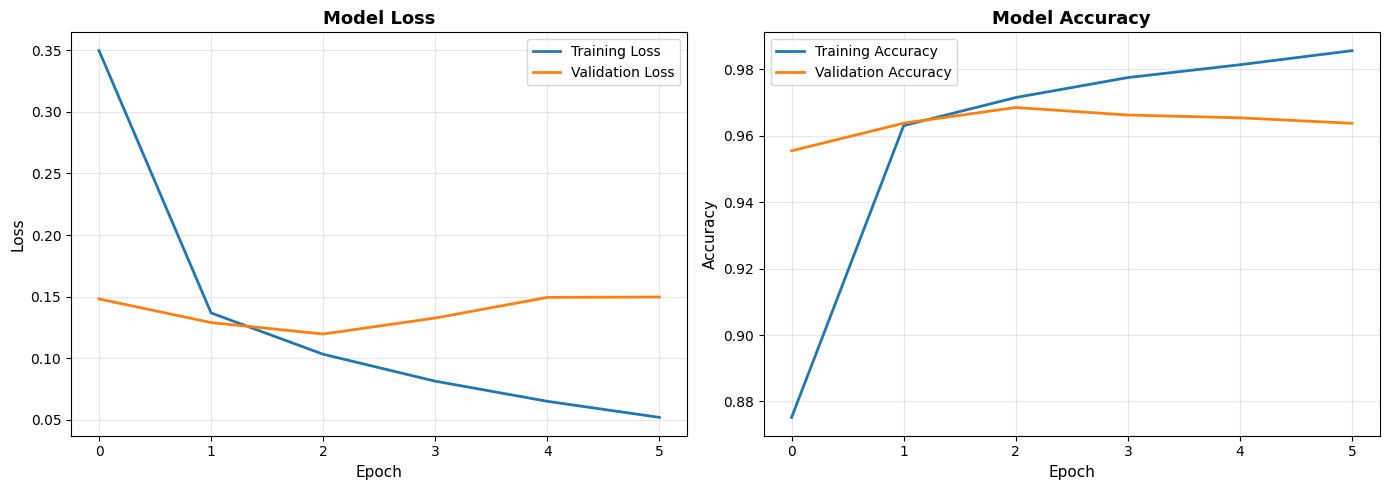

In [38]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()

## 7. Model Comparison


Final Results:
--------------------------------------------------
🥇 LSTM                : 0.9668 (96.68%)
🥈 Logistic Regression : 0.9071 (90.71%)
🥉 XGBoost             : 0.8541 (85.41%)
--------------------------------------------------

Best model: LSTM with accuracy 0.9668 (96.68%)


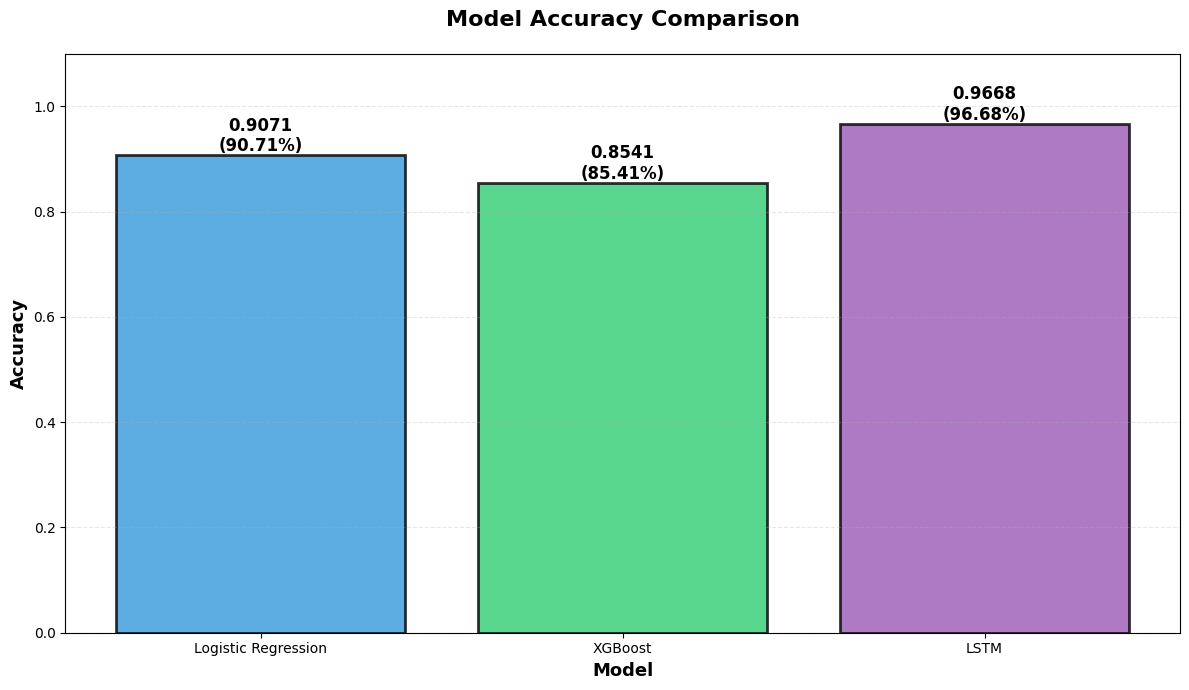

In [39]:
results = {
    'Logistic Regression': lr_acc,
    'XGBoost': xgb_acc,
    'LSTM': lstm_acc
}

# Sort results
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nFinal Results:")
print("-" * 50)
for i, (model, acc) in enumerate(sorted_results, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
    print(f"{medal} {model:20s}: {acc:.4f} ({acc*100:.2f}%)")
print("-" * 50)

# Plot comparison
plt.figure(figsize=(12, 7))
models = list(results.keys())
accuracies = list(results.values())
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}\n({height*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()


best_model = sorted_results[0][0]
best_acc = sorted_results[0][1]
print(f"\nBest model: {best_model} with accuracy {best_acc:.4f} ({best_acc*100:.2f}%)")

## 8. Prediction Test on New Texts

In [40]:
test_texts = [
    "Modi is doing great job for India development",
    "This government is terrible and corrupt",
    "Not sure about the new policies implemented"
]

label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

print("\n1. Logistic Regression:")
for i, text in enumerate(test_texts, 1):
    text_vec = tfidf_lr.transform([text])
    pred = lr_model.predict(text_vec)[0]
    print(f"   {i}. \"{text}\"")
    print(f"      → {label_names[pred]}\n")

print("\n2. XGBoost:")
for i, text in enumerate(test_texts, 1):
    text_vec = tfidf_xgb.transform([text])
    pred = xgb_model.predict(text_vec)[0]
    print(f"   {i}. \"{text}\"")
    print(f"      → {label_names[pred]}\n")

print("\n3. LSTM:")
for i, text in enumerate(test_texts, 1):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post', truncating='post')
    pred = np.argmax(lstm_model.predict(text_pad, verbose=0), axis=1)[0]
    print(f"   {i}. \"{text}\"")
    print(f"      → {label_names[pred]}\n")


1. Logistic Regression:
   1. "Modi is doing great job for India development"
      → Positive

   2. "This government is terrible and corrupt"
      → Negative

   3. "Not sure about the new policies implemented"
      → Positive


2. XGBoost:
   1. "Modi is doing great job for India development"
      → Positive

   2. "This government is terrible and corrupt"
      → Negative

   3. "Not sure about the new policies implemented"
      → Positive


3. LSTM:
   1. "Modi is doing great job for India development"
      → Positive

   2. "This government is terrible and corrupt"
      → Negative

   3. "Not sure about the new policies implemented"
      → Negative



## 9. Summary

In [41]:
print(f"\nProject Summary:")
print(f"   - Number of tweets: {len(df):,}")
print(f"   - Number of ML models: 3")
print(f"   - Best model: {best_model}")
print(f"   - Best accuracy: {best_acc*100:.2f}%")


Project Summary:
   - Number of tweets: 162,969
   - Number of ML models: 3
   - Best model: LSTM
   - Best accuracy: 96.68%


In [45]:
import pickle

lstm_model.save('sentiment_model.h5')

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model Saved Succefully")

Model Saved Succefully
